# NDCube Tutorial

This notebook is an introductory tutorial to the `ndcube` package which provides a framework for inspecting, analyzing and visualizing n-dimensional data.  The tutorial will start off providing some background context including the old paradigm of solar physics data analysis and tools that ndcube relies on, such as WCS (World Coordinate System).  It will then walk through the two primary classes of the `ndcube` package: `NDCube` and `NDCubeSequence`.

Before starting however, you will need to make sure you have the latest stable version of `ndcube`.  The recommended way to this is via the anaconda distribution.  If you don't already have anaconda, see the installation instructions (https://docs.anaconda.com/anaconda/install/).

Once you have anaconda installed, install ndcube by typing the following into a terminal:

`$ conda install --channel conda-forge ndcube`

You should now be ready to start this tutorial.

In [1]:
# Import packages we will be using this tutorial here.
from datetime import datetime, timedelta

import numpy as np
from astropy.io import fits
import astropy.wcs
import astropy.units as u
import matplotlib.pyplot as plt
from sunpy.time import parse_time

from ndcube import NDCube, NDCubeSequence

The 'recommended_units' attribute is deprecated since 3.0 and may be removed
in a future version. Its main use, of representing angles in degrees in frames,
is now done automatically in frames. Further overrides are discouraged but can
be done using a frame's ``frame_specific_representation_info``.
 [astropy.coordinates.representation]


In [2]:
# Enable interactive plotting windows within the notebook.
% matplotlib notebook

Before we start, let's read in some IRIS spectrograph data that we will use throughout this tutorial as an example.

In [3]:
# Define the filepath and filename for data which we will use in this tutorial.
filename0 = "iris_l2_20141211_191222_3803105278_raster_t000_r00000.fits"
filename1 = "iris_l2_20141211_191222_3803105278_raster_t000_r00001.fits"
filename2 = "iris_l2_20141211_191222_3803105278_raster_t000_r00002.fits"

In [4]:
# Create a list of Header Data Unit (HDUs) or FITS extensions from a sample file.
hdulist = fits.open(filename0)

In [5]:
hdulist

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x1c186ffc18>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c1871f2e8>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c1871fbe0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c18725cc0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c1872ada0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c1872fe80>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c18734f60>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c1873e828>, <astropy.io.fits.hdu.image.ImageHDU object at 0x1c18744ba8>, <astropy.io.fits.hdu.table.TableHDU object at 0x1c1874a898>]

## Background Context

### World Coordinate System

The World Coordinate System (WCS) is a framework of mathematical translations and well defined variable names that describe the conversion from pixel/array coordinates to the real world coordinates (e.g. latitude, time, wavelength) of the location in the Universe represented by the pixels.

WCS parameters can be defined manually by a user but are often stored in the headers of FITS files.

In [6]:
hdulist[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                   16 / Number of bits per data pixel                  
NAXIS   =                    3 / Number of data axes                            
NAXIS1  =                  333 /                                                
NAXIS2  =                  548 /                                                
NAXIS3  =                    8 /                                                
PCOUNT  =                    0 / No Group Parameters                            
GCOUNT  =                    1 / One Data Group                                 
BSCALE  =                 0.25 /                                                
BZERO   =                 7992 /                                                
CDELT1  =            0.0259600 /                                                
CDELT2  =             0.332700 /                                                
CDELT3  =       0.9977201734

Many of these variables, such as those start with 'C' or 'PC' are reserved variable names defined by the WCS standard and have been common in solar physics since at least the age of the STEREO mission. 

In [7]:
hdulist.close()

### Old Paradigm of Data Analysis

Many solar physicists handle their data and WCS information in a very cumbersome way. The data and WCS information are manipulated separately and manually. For example, let's find a region of interest in a spectrogram observation file between 1400 and 1450 angstrom:

In [8]:
# Read data file and extract header and data from 1st (0-based counting) HDU/FITS extension.
hdulist = fits.open(filename0)
header = hdulist[1].header
data = hdulist[1].data
hdulist.close()

In [9]:
data.shape

(8, 548, 333)

The above shows us the length of each axis of the data array.  But this is of limited value unless we have information on the axes of that data.  This can be obtained from the WCS variables in the header, shown above.

Due to unfortunate and confusing convention, the ordering of the WCS axes are reversed relative to the data axes.  This means that the WCS variables ending in '1' actually describe the final data axis.
`CTYPE1='WAVE'`
tells us that the 3rd data axis is wavelength.  So let's calculate the wavelength value for each pixel in along the final axis of the data.

In [10]:
origin = 0

In [11]:
wave = header["CRPIX1"]*np.arange(333)+header["CRVAL1"]+origin

In [12]:
wave

array([1331.9, 1332.9, 1333.9, 1334.9, 1335.9, 1336.9, 1337.9, 1338.9,
       1339.9, 1340.9, 1341.9, 1342.9, 1343.9, 1344.9, 1345.9, 1346.9,
       1347.9, 1348.9, 1349.9, 1350.9, 1351.9, 1352.9, 1353.9, 1354.9,
       1355.9, 1356.9, 1357.9, 1358.9, 1359.9, 1360.9, 1361.9, 1362.9,
       1363.9, 1364.9, 1365.9, 1366.9, 1367.9, 1368.9, 1369.9, 1370.9,
       1371.9, 1372.9, 1373.9, 1374.9, 1375.9, 1376.9, 1377.9, 1378.9,
       1379.9, 1380.9, 1381.9, 1382.9, 1383.9, 1384.9, 1385.9, 1386.9,
       1387.9, 1388.9, 1389.9, 1390.9, 1391.9, 1392.9, 1393.9, 1394.9,
       1395.9, 1396.9, 1397.9, 1398.9, 1399.9, 1400.9, 1401.9, 1402.9,
       1403.9, 1404.9, 1405.9, 1406.9, 1407.9, 1408.9, 1409.9, 1410.9,
       1411.9, 1412.9, 1413.9, 1414.9, 1415.9, 1416.9, 1417.9, 1418.9,
       1419.9, 1420.9, 1421.9, 1422.9, 1423.9, 1424.9, 1425.9, 1426.9,
       1427.9, 1428.9, 1429.9, 1430.9, 1431.9, 1432.9, 1433.9, 1434.9,
       1435.9, 1436.9, 1437.9, 1438.9, 1439.9, 1440.9, 1441.9, 1442.9,
      

This gives us an array in Angstroms (see `CUNIT1='Angstrom'` in the header).

Fortunately, the WCS translation from pixels to wavelength is a simple linear one, and so was easy for us to calculate.  However, translations for other physical properties can be far more complicated, with rotations, distortions, etc.  This information is described by other WCS variables that we did not use above, such as those starting 'PC'.  For now, though, let's ignore this complexity.

Now we have our wavelength array, let's use it to crop our data to a region of interest between 1400 and 1450 Angstrom.

In [13]:
w = np.logical_and(wave>=1400., wave<1450.)

In [14]:
w

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False,

In [15]:
wave[w]

array([1400.9, 1401.9, 1402.9, 1403.9, 1404.9, 1405.9, 1406.9, 1407.9,
       1408.9, 1409.9, 1410.9, 1411.9, 1412.9, 1413.9, 1414.9, 1415.9,
       1416.9, 1417.9, 1418.9, 1419.9, 1420.9, 1421.9, 1422.9, 1423.9,
       1424.9, 1425.9, 1426.9, 1427.9, 1428.9, 1429.9, 1430.9, 1431.9,
       1432.9, 1433.9, 1434.9, 1435.9, 1436.9, 1437.9, 1438.9, 1439.9,
       1440.9, 1441.9, 1442.9, 1443.9, 1444.9, 1445.9, 1446.9, 1447.9,
       1448.9, 1449.9])

In [16]:
# Crop data to the range 1400 to 1450 Angstrom
data_roi = data[:, :, w]

In [17]:
data_roi.shape

(8, 548, 50)

However, now we've changed the shape of our data, the same pixel coordinate does not correspond to the same real world coordinate. So we have to make sure the original mapping persists in our analysis. The simplest way is to create a new wavelength array for the region of interest.

In [18]:
wave_roi = wave[w]

In [19]:
wave_roi

array([1400.9, 1401.9, 1402.9, 1403.9, 1404.9, 1405.9, 1406.9, 1407.9,
       1408.9, 1409.9, 1410.9, 1411.9, 1412.9, 1413.9, 1414.9, 1415.9,
       1416.9, 1417.9, 1418.9, 1419.9, 1420.9, 1421.9, 1422.9, 1423.9,
       1424.9, 1425.9, 1426.9, 1427.9, 1428.9, 1429.9, 1430.9, 1431.9,
       1432.9, 1433.9, 1434.9, 1435.9, 1436.9, 1437.9, 1438.9, 1439.9,
       1440.9, 1441.9, 1442.9, 1443.9, 1444.9, 1445.9, 1446.9, 1447.9,
       1448.9, 1449.9])

Here, we have outlined a very simple case. But for this data we could also have an array of latitude, longitude, and time to describe the mappings from pixel coordinates to real world coordinates. This means we would need a `data`, `wave`, `latitude`, `longitude`, and `time` array to describe the whole observation, and then a `data_roi`, `wave_roi`, `latitude_roi`, `longituge_roi`, and `time_roi` arrays to describe one region of interest. This is a lot of arrays to keep track of and often leads to mistakes. Moreover, the arrays are typically determined by manually applying the transformation equations, again often leading to mistakes.

We may also have other types of supporting data, like an `uncertainty` array for the measurement uncertainty. We may also have separate data cubes with separate WCS translations from different files within the same observing campaign.

It also means it is hard to share partially analysed data in a way that someone else would understand.  In fact, it can even be difficult for you to understand your own work if you have not looked at in a while.  Hence the phrase:

##### "When I wrote this code only God and I knew what it did.  Now God only knows!"

Before moving onto ndcube, let's discuss one of the important packages on which it depends.

### AstroPy WCS

WCS has been used in astronomy for decades.  This is why the AstroPy community has already written a WCS class that understands the standardized WCS variable and transformation names.  All important WCS information is stored within the object and then applied through some easIER-to-use functions.  A WCS object can be created from a FITS header or a Python dictionary:

In [20]:
wcs = astropy.wcs.WCS(header)

In [21]:
wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
CRPIX : 1.0  274.5  4.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
NAXIS : 333  548  8

Note again that the ordering of the axes within the WCS object is reversed relative to the data.

#### As a side note, the Python astronomy community is more advanced than the solar physics one.  And because of the open-source nature of packages like astropy, we in solar physics can leverage a huge amount of what has been done already.  This means we can either pool resources to develop higher quality packages that are useful across disciplines, thereby saving time and money by not reinventing the wheel over and over again.  Or we can use the time saved to develop more specialized tools for our purposes.  This is a tactic you will see time and time again in ndcube and in SunPy.

Back to WCS, we can use the above wcs instance to convert from pixel coordinates to real world coordinates by using the `all_pix2world` method:

In [22]:
# For the (0,0,0) pixel in the data array:
wcs.all_pix2world(np.array([[0,0,0]]), origin)

array([[ 1.33190000e-07, -9.77322378e-02,  2.29960913e-03]])

To go from real world coordinates to pixel coordinates, use the `all_world2pix` method:

In [23]:
# For the (1.340e-7 deg, -9.8e-2 deg, 2.5e-3 m) pixel in the data array:
wcs.all_world2pix(np.array([[1.340e-7, -9.8e-2, 2.5e-3]]), origin)

array([[312.01848998,  -2.87268793,   0.73390562]])

### Astropy Quantities

You may have remember that when we constructed the wavelength values, we produced a simple array.  The array had no knowledge of the units it was in.  As users, we just had to know that it was in arcsec.  This is a fine approach when we are quickly putting together some analysis code, but requires that the units of our data be documented clearly somewhere obvious if ever we want to revisit our analysis after a break, or share our code with others.  Unfortunately this is often not done and leads to errors in analysis and leads to a lot of wasted time and we and others we share our code with struggle to work out afresh each time what unit things are in.

To solve this problem, Astropy has developed an `astropy.units.Quantity` class which combines a number or numeric array with an `astropy.units.unit` class.  At the top of this notebook we import the `astropy.units` module as `u`.  So let's use it to create a wavelength quantity.  This can be done through a formal constructor, or simply by multiplying a number or numeric array by a Unit object.

In [24]:
wave_quantity = u.Quantity(wave, unit=u.angstrom) # where u.angstrom is the Angstrom unit object available in the astropy units module.
# The following commands will produce the same result:
# wave_quantity = u.Quantity(wave, unit="Angstrom")
# wave_quantity = wave * u.Angstrom

In [25]:
wave_quantity

<Quantity [1331.9, 1332.9, 1333.9, 1334.9, 1335.9, 1336.9, 1337.9, 1338.9,
           1339.9, 1340.9, 1341.9, 1342.9, 1343.9, 1344.9, 1345.9, 1346.9,
           1347.9, 1348.9, 1349.9, 1350.9, 1351.9, 1352.9, 1353.9, 1354.9,
           1355.9, 1356.9, 1357.9, 1358.9, 1359.9, 1360.9, 1361.9, 1362.9,
           1363.9, 1364.9, 1365.9, 1366.9, 1367.9, 1368.9, 1369.9, 1370.9,
           1371.9, 1372.9, 1373.9, 1374.9, 1375.9, 1376.9, 1377.9, 1378.9,
           1379.9, 1380.9, 1381.9, 1382.9, 1383.9, 1384.9, 1385.9, 1386.9,
           1387.9, 1388.9, 1389.9, 1390.9, 1391.9, 1392.9, 1393.9, 1394.9,
           1395.9, 1396.9, 1397.9, 1398.9, 1399.9, 1400.9, 1401.9, 1402.9,
           1403.9, 1404.9, 1405.9, 1406.9, 1407.9, 1408.9, 1409.9, 1410.9,
           1411.9, 1412.9, 1413.9, 1414.9, 1415.9, 1416.9, 1417.9, 1418.9,
           1419.9, 1420.9, 1421.9, 1422.9, 1423.9, 1424.9, 1425.9, 1426.9,
           1427.9, 1428.9, 1429.9, 1430.9, 1431.9, 1432.9, 1433.9, 1434.9,
           1435.9, 1436.9

As well as labelling the units of an array, `Quantities` can also be used in arithmetic calculations.  For example, if we divide a distance quantity with a time quantity, we will get a speed quantity:

In [26]:
speed = (10*u.m) / (2*u.s)

In [27]:
speed

<Quantity 5. m / s>

`Quantities` also prevent us from making silly mistakes, like adding things that don't make sense.

In [28]:
(10*u.m) + (2*u.s)

UnitConversionError: Can only apply 'add' function to quantities with compatible dimensions

Finally, `Quantities` make converting between compatible units incredibly easy:

In [29]:
speed

<Quantity 5. m / s>

In [30]:
speed.to(u.cm/u.s)

<Quantity 500. cm / s>

In [31]:
speed.to("cm/s")

<Quantity 500. cm / s>

As well as being extremely useful for individual scientists' analysis code, `Quantities` are utilized extensively by ndcube (and SunPy) so we will see them pop up throughout this tutorial.

The useful packages outlined above still do not solve the problem of handling the data, metadata, WCS, and any supporting data (e.g. uncertainty) separately which is cumbersome, prone to errors and hard to understand later.  It is these problems, among others, that the ndcube package solves.  Let's now delve into ndcube!

## NDCube

The ndcube package contains two basic classes for handling ND data: `NDCube` and `NDCubeSequence`.  `NDCube` is the fundamental class of the ndcube package and is designed to handle data contained in a single N-D array described by a single set of WCS transformation.  `NDCube` is subclassed from `astropy.nddata.NDData` and so inherits the same attributes for data, wcs, uncertainty, mask, meta, and unit.  The WCS object contained in the ``.wcs`` attribute is subclassed from `astropy.wcs.WCS` and contains a few additional attributes to enable to keep track of its relationship to the data.

### Initialization

To initialize the most basic `NDCube` object, all you need is a `numpy.ndarray` containing the data, and an `astropy.wcs.WCS` object describing the transformation from array-element space to real world coordinates.  Let's use the data we've explored already to make an `NDCube`.

In [32]:
# Read data from file.
hdulist = fits.open(filename0)
data = hdulist[1].data
input_wcs = astropy.wcs.WCS(hdulist[1].header)
hdulist.close()

In [33]:
# Create an NDCube.
my_cube = NDCube(data, input_wcs)

In [34]:
my_cube

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
CRPIX : 1.0  274.5  4.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
NAXIS : 333  548  8
---------------------
Length of NDCube: [  8. 548. 333.] pix
Axis Types of NDCube: ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

The data array is stored in the ``mycube.data`` attribute while the WCS object is stored in the ``my_cube.wcs`` attribute.  However, when manipulating/slicing the data is it better to slice the object as a whole.  (See section on Slicing, below.)  So the ``.data`` attribute should only be used to access a specific value(s) in the data.

In [35]:
my_cube.data

array([[[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]],

       [[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]],

       [[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -20

In [36]:
my_cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
CRPIX : 1.0  274.5  4.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
NAXIS : 333  548  8

Another thing to note is that as part of the initialization, the WCS object is converted from an `astropy.wcs.WCS` to an `ndcube.utils.wcs.WCS` object which has some additional features for tracking "missing axes", etc. (See section on Missing Axes.)

Thanks to the fact that `NDCube` is subclassed from `astropy.nddata.NDData`, you can also supply additional data to the `NDCube` instance.  These include: metadata (`dict` or dict-like) located at `NDCube.meta`; a data mask (boolean `numpy.ndarray`) located at`NDCube.mask` highlighting, for example, reliable and unreliable pixels; an uncertainty array (`numpy.ndarray`) located at `NDCube.uncertainty` describing the uncertainty of each data array value; and a unit (`astropy.units.Unit` or unit `str`). For example:

In [37]:
mask = np.zeros_like(data, dtype=bool)
meta = {"Description": "This is example NDCube metadata."}
my_cube = NDCube(data, input_wcs, uncertainty=np.sqrt(data), mask=mask, meta=meta)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


N.B. The above warning is due to the fact that `astropy.nddata.uncertainty` is recommended to have an ``uncertainty_type`` attribute giving a string describing the type of uncertainty.  However, this is not required.

In [38]:
my_cube.mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [39]:
my_cube.meta

{'Description': 'This is example NDCube metadata.'}

### Dimensions

`NDCube` has useful properties for inspecting its data shape and axis types, namely `NDCube.dimensions` and `NDCube.world_axis_physical_types`:

In [40]:
my_cube.dimensions

<Quantity [  8., 548., 333.] pix>

In [41]:
my_cube.world_axis_physical_types

('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

`NDCube.dimensions` returns an `Quantity` of pixel units giving the length of each dimension in the `NDCube` while `NDCube.world_axis_physical_types` returns an iterable of strings denoting the type of physical property represented by each axis.  The axis names are in accordance with the International Virtual Observatory Alliance (IVOA) UCD1+ controlled vocabulary (http://www.ivoa.net/documents/REC/UCD/UCDlist-20070402.html). Here the shape and axis types are given in data order, not WCS order.

### Slicing

Arguably NDCube's most powerful capability is its slicing.  Slicing an `NDCube` instance using the standard slicing notation allows users to access sub-regions of their data while simultaneously slicing not only the other array attributes (e.g. uncertainty, mask, etc.) but also the WCS object.  This ensures that even though the data array has changed size and shape, each array element will still correspond to the same real world coordinates as they did before.  An example of how to slice a 3-D `NDCube` object is:

In [42]:
my_cube_roi = my_cube[3:5, 10:100, 30:37]

In [43]:
my_cube_roi.dimensions

<Quantity [ 2., 90.,  7.] pix>

Slicing can also reduce the dimension of an `NDCube`, e.g.:

In [44]:
my_2d_cube = my_cube[0, 10:100, 30:37]

In [45]:
my_2d_cube.dimensions

<Quantity [90.,  7.] pix>

In [46]:
my_cube.missing_axis

[False, False, False]

In [47]:
my_2d_cube.missing_axis

[False, False, True]

In addition to slicing by index, `NDCube` supports a basic version of slicing/indexing by real world coordinates via the `NDCube.crop_by_coords` method.  This takes a list of `astropy.units.Quantity` instances representing the minimum real world coordinates of the region of interest in each dimension.  The order of the coordinates must be the same as the order of the data axes.  A second iterable of `Quantities` must also be provided which gives the widths of the region of interest in each data axis:

In [48]:
my_cube_roi = my_cube.crop_by_coords(
    [u.Quantity(0.003, unit="deg"), u.Quantity(-0.09, unit="deg"), u.Quantity(1.333e-7, unit="m")],
    [u.Quantity(0.001, unit="deg"), u.Quantity(0.04, unit="deg"), u.Quantity(0.001e-7, unit="m")])

In [49]:
my_cube_roi.dimensions

<Quantity [  2., 433.,  39.] pix>

This method does not rebin or interpolate the data if the region of interest does not perfectly map onto the array's "pixel" grid.  Instead it translates from real world to pixel coordinates and rounds to the nearest integer pixel before indexing/slicing the `NDCube` instance. Therefore it should be noted that slightly different inputs to this method can result in the same output.

### Missing Axes

Some WCS axis types are coupled.  For example, the helioprojective latitude and longitude of the Sun as viewed by a camera on a satellite orbiting Earth do not map independently to the pixel grid.  Instead, the longitude changes as we move vertically along the same x-position if that single x-position is aligned anywhere other than perfectly north-south along the Sun's central meridian.  The analagous is true of the latitude for any y-pixel position not perfectly aligned with the Sun's equator. Therefore, knowledge of both the latitude and longitude must be known to derive the pixel position along a single spatial axis and vice versa.

However, there are occasions when a data array may only contain one spatial axis, e.g. data from a slit-spectrograph.  In this case, simply extracting the corresponding latitude or longitude axis from the WCS object would cause the translations to break.

To deal with this scenario, `NDCube` supports "missing" WCS axes.  An additional attribute is added to the WCS object (`NDCube.wcs.missing_axis`) which is a list of `bool` type indicating which WCS axes do not have a corresponding data axis.  This allows translation information on coupled axes to persist even if the data axes do not.  This feature also makes it possible for `NDCube` to seamlessly reduce the data dimensionality via slicing.  In the majority of cases a user will not need to worry about this feature.  But it is useful to be aware of as many of the coordinate transformation functionalities of `~ndcube.NDCube` are only made possible by the missing axis feature.  It also helps to explain why it is recommended to slice an `NDCube` instance as a whole rather than slicing the `.data`, `.uncertainty`, etc. arrays individually.

In [50]:
my_cube.missing_axis

[False, False, False]

### Extra Coordinates

In the case of some datasets, there may be additional translations between the array elements and real world coordinates that are not included in the WCS.  Consider the sample data used in this tutorial.  The first axis corresponds to the x-position of the slit as it steps across a region of interest in a given pattern.  The second corresponds to latitude along the slit.  And the third axis corresponds to wavelength.  However, the first axis also corresponds to time, as it takes time for the slit to move and then take another exposure. It would be very useful to have the measurement times also associated with the x-axis.  However, the WCS only contains one translation per axis.

Fortunately, `NDCube` has a solution to this.  Values at integer (pixel) steps along an axis can be stored within the object and accessed via the `NDCube.extra_coords` property. To attach extra coordinates to an `NDCube` instance, provide an iterable of tuples of the form (`str`, `int`, `Quantity` or array-like) during instantiation.  The 0th entry gives the name of the coordinate, the 1st entry gives the data axis to which the extra coordinate corresponds, and the 2nd entry gives the value of that coordinate at each pixel along the axis.  So, to add timestamps along the 0th axis of ``my_cube`` we do:

In [51]:
# Define our timestamps.  Must be same length as data axis.
axis_length = int(my_cube.dimensions[0].value)
timestamps = [datetime(2000, 1, 1)+timedelta(minutes=i) for i in range(axis_length)]
extra_coords_input = [("time", 0, timestamps)]
# Generate NDCube as above, except now set extra_coords kwarg.
my_cube = NDCube(data, input_wcs, uncertainty=np.sqrt(data), mask=mask, meta=meta, unit=None, 
                 extra_coords=extra_coords_input)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [52]:
timestamps

[datetime.datetime(2000, 1, 1, 0, 0),
 datetime.datetime(2000, 1, 1, 0, 1),
 datetime.datetime(2000, 1, 1, 0, 2),
 datetime.datetime(2000, 1, 1, 0, 3),
 datetime.datetime(2000, 1, 1, 0, 4),
 datetime.datetime(2000, 1, 1, 0, 5),
 datetime.datetime(2000, 1, 1, 0, 6),
 datetime.datetime(2000, 1, 1, 0, 7)]

The `NDCube.extra_coords` property returns a `dict` where each key is a coordinate name entered by the user.  The value of each key is itself another dictionary with keys ``'axis'`` and ``'value'`` giving the corresponding data axis number and coordinate value at each pixel as supplied by the user:

In [53]:
my_cube.dimensions

<Quantity [  8., 548., 333.] pix>

In [54]:
my_2d_cube.dimensions

<Quantity [90.,  7.] pix>

In [55]:
my_cube.extra_coords

{'time': {'axis': 0,
  'value': [datetime.datetime(2000, 1, 1, 0, 0),
   datetime.datetime(2000, 1, 1, 0, 1),
   datetime.datetime(2000, 1, 1, 0, 2),
   datetime.datetime(2000, 1, 1, 0, 3),
   datetime.datetime(2000, 1, 1, 0, 4),
   datetime.datetime(2000, 1, 1, 0, 5),
   datetime.datetime(2000, 1, 1, 0, 6),
   datetime.datetime(2000, 1, 1, 0, 7)]}}

Just like the data array and the WCS object, the extra coordinates are sliced automatically when the `NDCube` instance is sliced.  So if we take the first slice of ``my_cube`` in the 0th axis, the extra time coordinate will only contain the value from that slice.

In [56]:
my_cube[0].extra_coords

{'time': {'axis': None, 'value': datetime.datetime(2000, 1, 1, 0, 0)}}

Note that the ``axis`` value is now ``None`` because the dimensionality of the `NDCube` has been reduced via the slicing

In [57]:
my_cube[0].dimensions

<Quantity [548., 333.] pix>

and so the ``time`` extra coordinate no longer corresponds to a data axis.  This would not have been the case if we had done the slicing so the length of the 0th axis was >1.

In [58]:
my_cube[0:2].dimensions

<Quantity [  2., 548., 333.] pix>

In [59]:
my_cube[0:2].extra_coords

{'time': {'axis': 0,
  'value': [datetime.datetime(2000, 1, 1, 0, 0),
   datetime.datetime(2000, 1, 1, 0, 1)]}}

### Plotting

To quickly and easily visualize N-D data, `~ndcube.NDCube` provides a simple-to-use, yet powerful plotting method, `~ndcube.NDCube.plot`, which produces a sensible visualization based on the dimensionality of the data.  It is intended to be a useful quicklook tool and not a replacement for high quality plots or animations, e.g. for publications.  The plot method can be called very simply, like so:

<IPython.core.display.Javascript object>


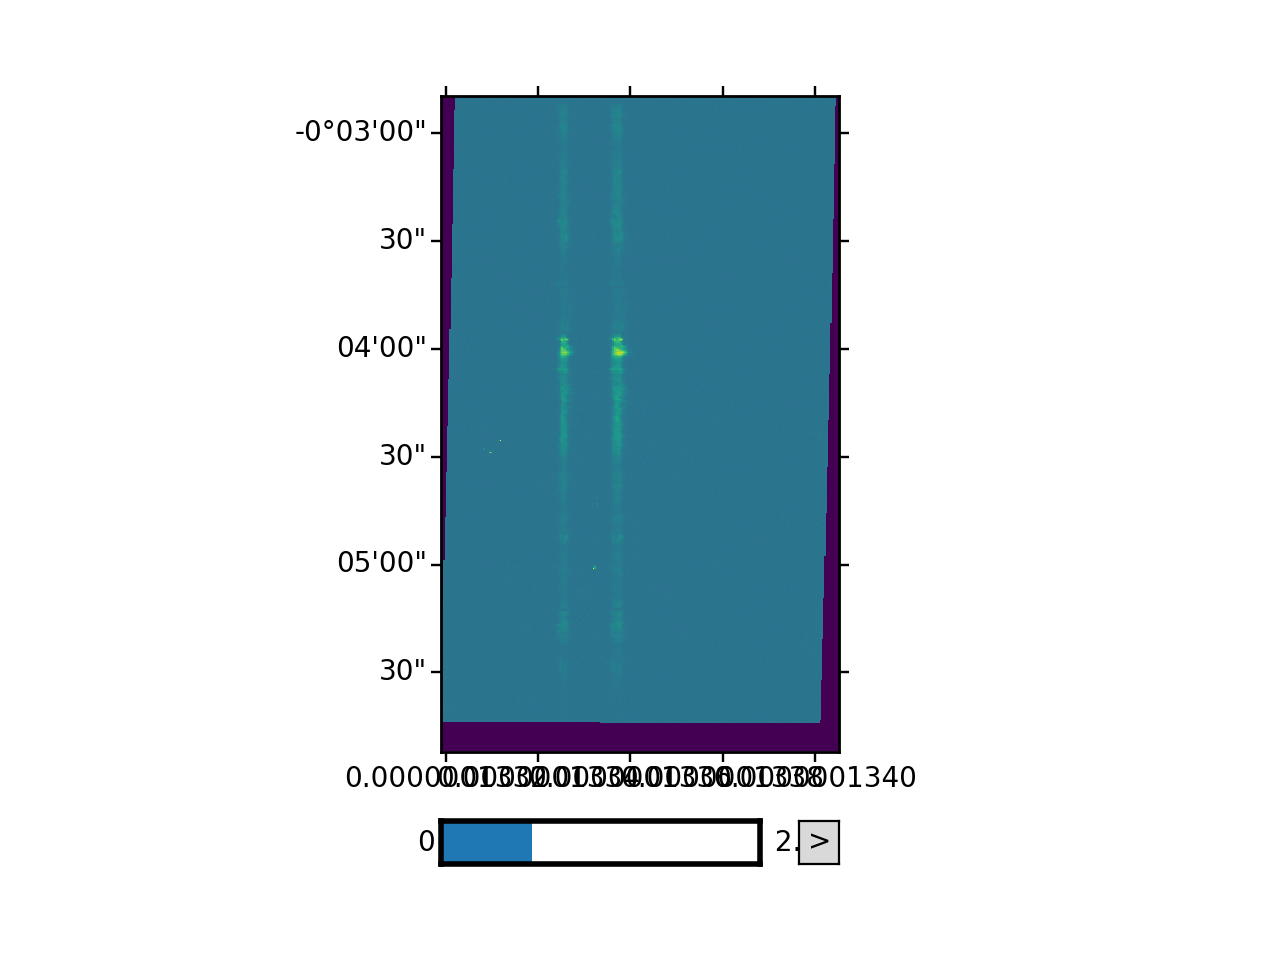

In [60]:
# Visualize all in the NDCube as an animation.
my_cube.plot()

The type of visualization returned depends on the dimensionality of the data within the `NDCube` object.  For 1-D data a line plot is produced, similar to `matplotlib.pyplot.plot`.  For 2-D data, an image is produced similar to that of `matplotlib.pyplot.imshow`. While for a >2-D data, a `sunpy.visualization.imageanimator.ImageAnimatorWCS` object is returned.  This displays a 2-D image with sliders for each additional dimension which allow the user to animate through the different values of each dimension and see the effect in the 2-D image.  An example of this is seen above.

No args are required.  The necessary information to generate the plot is derived from the data and metadata in the `NDCube` itself. Setting the x and y ranges of the plot can be done simply by indexing the `NDCube` object itself to the desired region of interest and then calling the plot method, e.g.:

<IPython.core.display.Javascript object>


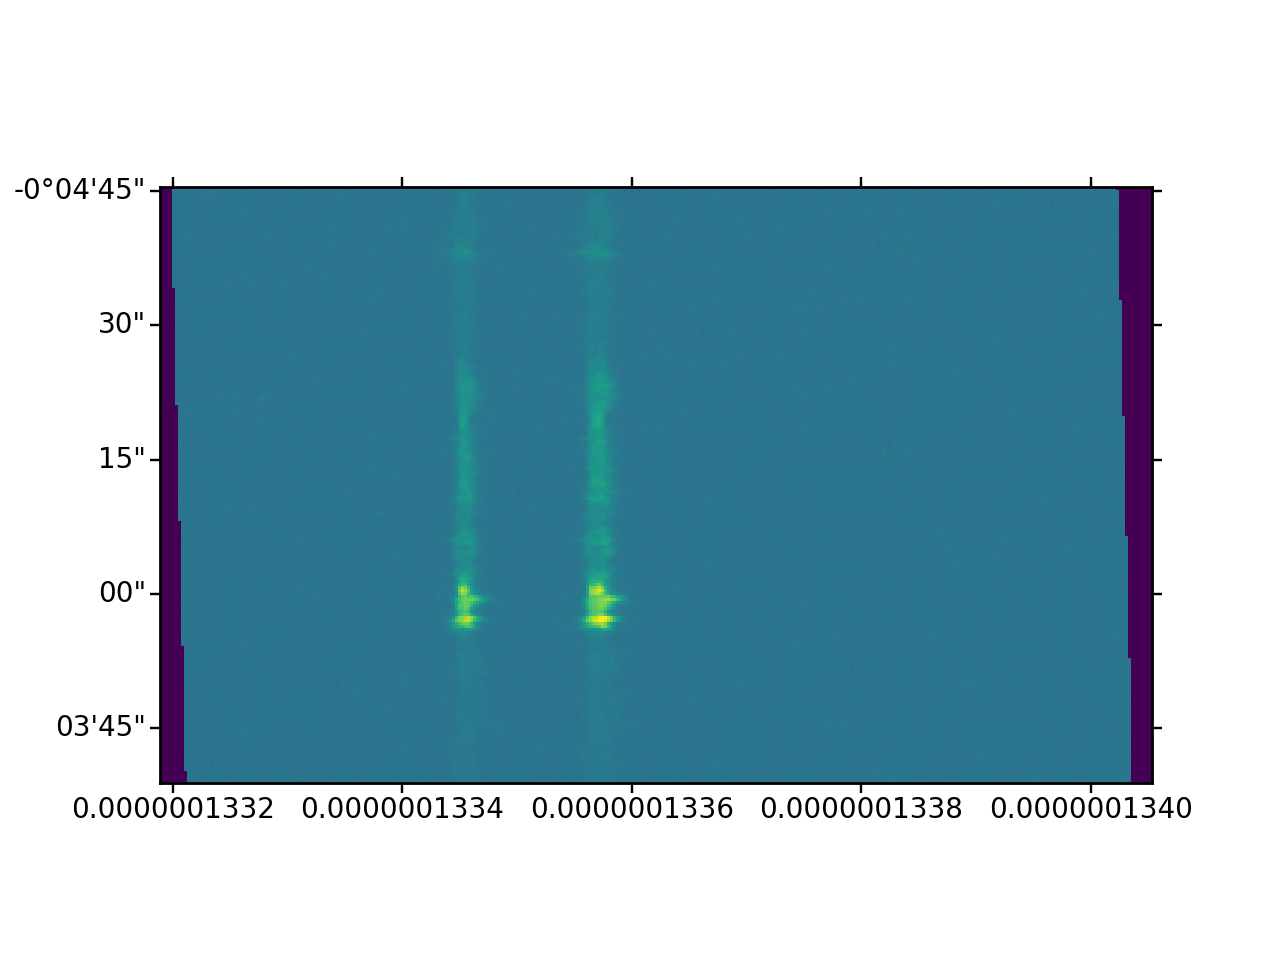

In [61]:
# Plot a subregion of the 0th exposure as a 2D image.
my_cube[0, 200:400, :].plot()

<IPython.core.display.Javascript object>


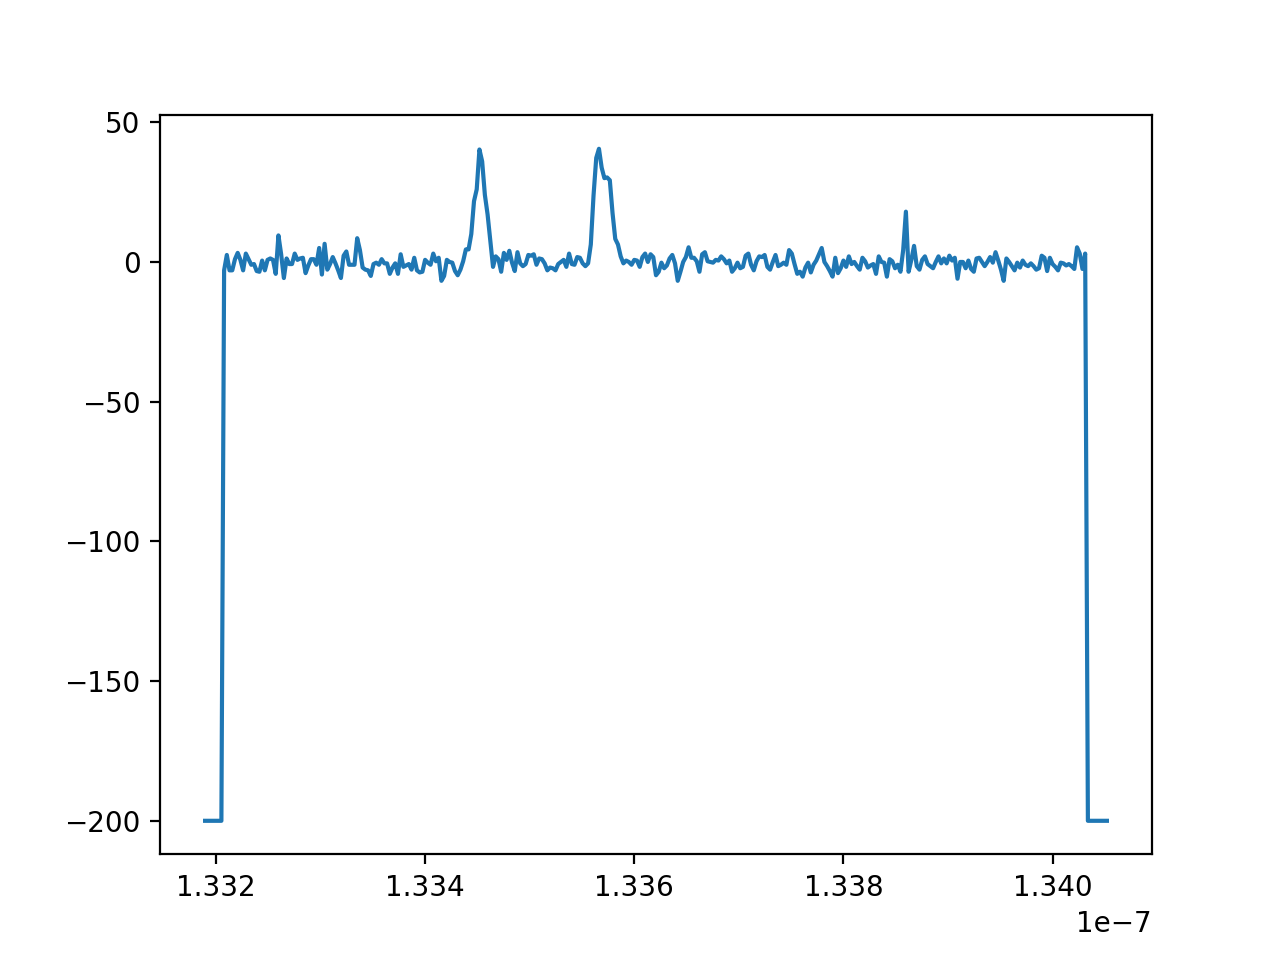

In [62]:
# Plot a 1D spectrum from a single latitude in the 0th exposure.
my_cube[0, 350, :].plot()

In addition, some optional kwargs can be used to customize the plot.  The ``axis_ranges`` kwarg can be used to set the axes ticklabels.  See the `~sunpy.visualization.imageanimator.ImageAnimatorWCS` documentation for more detail.  However, if this is not set, the axis ticklabels are automatically derived in real world coordinates from the WCS object within the `NDCube`.

By default the final two data dimensions are used for the plot axes in 2-D or greater visualizations, but this can be set by the user using the ``images_axes`` kwarg:

<IPython.core.display.Javascript object>


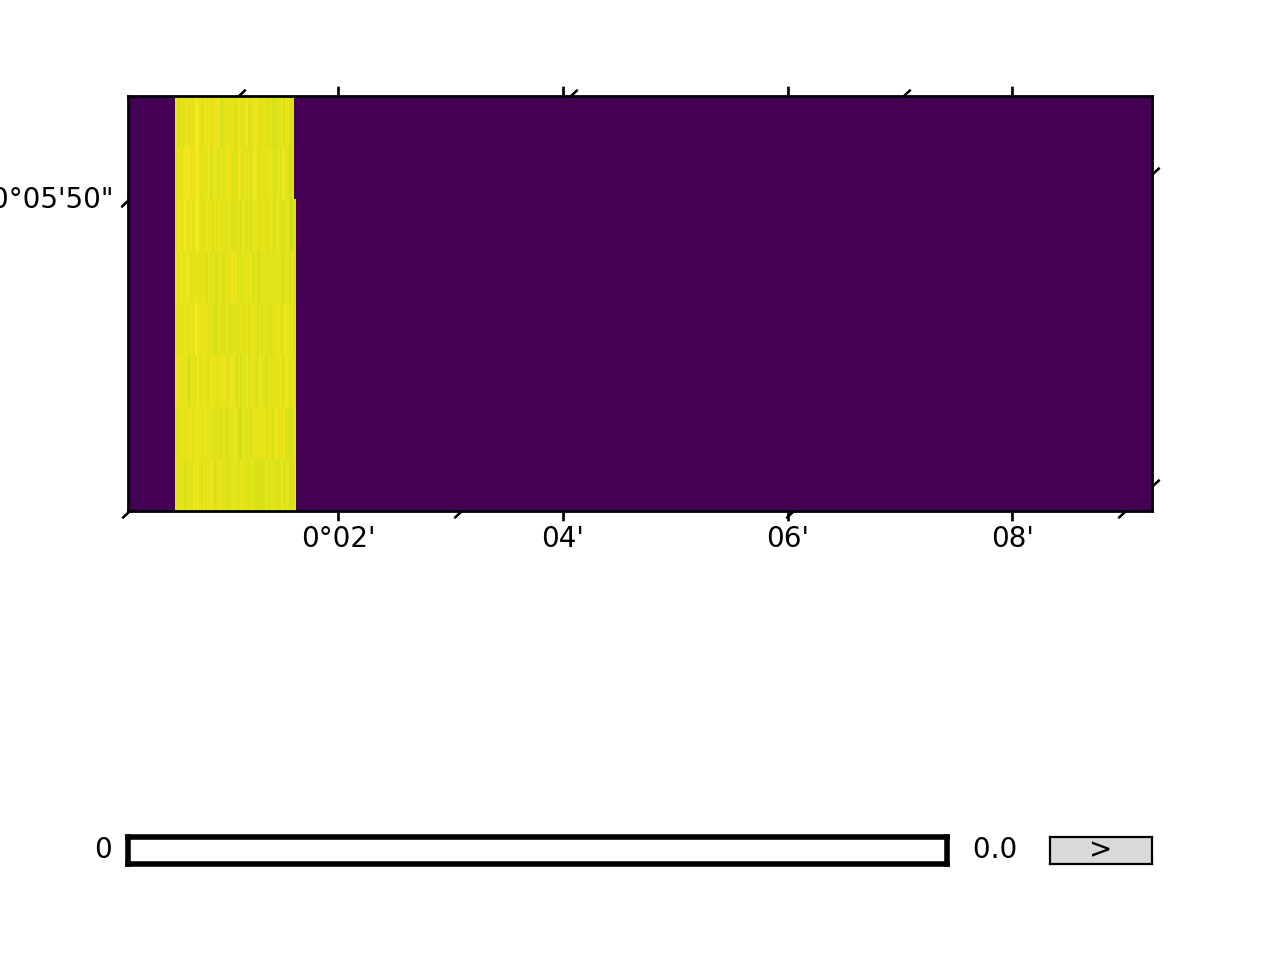

In [64]:
my_cube.plot(image_axes=[0,1], aspect="auto")

where the first entry in the list gives the index of the data index to go on the x-axis, and the second entry gives the index of the data axis to go on the y-axis.

In addition, the units of the axes or the data can be set by the ``unit_x_axis``, ``unit_y_axis``, unit kwargs.  However, if not set, these are derived from the `NDCube` wcs and unit attributes.

### Coordinate Transformations

The fundamental point the WCS system is the ability to easily translate between pixel and real world coordinates.  For this purpose, `NDCube` provides convenience wrappers for the better known astropy functions, `astropy.wcs.WCS.all_pix2world` and `astropy.wcs.WCS.all_world2pix`. These are `NDCube.pixel_to_world`, `NDCube.world_to_pixel`, and `NDCube.all_world_coords`. It is highly recommended that when using `NDCube` these convenience wrappers are used rather than the original astropy functions for a few reasons. For example, they can track house-keeping data, are aware of "missing" WCS axis, are unit-aware, etc.

To use `pixel_to_world`, simply input `Quantity` objects with pixel units. Each `Quantity` corresponds to an axis so the number of `Quantity` objects should equal the number of data axes.  Also, the order of the quantities should correspond to the data axes' order, not the WCS order.  The nth element of each `Quantity` describes the pixel coordinate in that axis. For example, if we wanted to transform the pixel coordinates of the pixel (2, 3, 4) in ``my_cube`` we would do:

In [65]:
real_world_coords = my_cube.pixel_to_world(u.Quantity([2], unit=u.pix), 
                                           u.Quantity([3], unit=u.pix), 
                                           u.Quantity([4], unit=u.pix))

In [66]:
real_world_coords

[<Quantity [0.00285699] deg>,
 <Quantity [-0.09746126] deg>,
 <Quantity [1.33200384e-07] m>]

To convert two pixels with pixel coordinates (2, 3, 4) and (5, 6, 7), we would call pixel_to_world like so:

In [67]:
real_world_coords = my_cube.pixel_to_world(u.Quantity([2, 5], unit=u.pix), 
                                           u.Quantity([3, 6], unit=u.pix), 
                                           u.Quantity([4, 7], unit=u.pix))

In [68]:
real_world_coords

[<Quantity [0.00285699, 0.0036915 ] deg>,
 <Quantity [-0.09746126, -0.0971934 ] deg>,
 <Quantity [1.33200384e-07, 1.33208172e-07] m>]

As can be seen, since each `Quantity` describes a different pixel coordinate of the same number of pixels, the lengths
of each `Quantity` must be the same.

The exact units used are defined within the `NDCube` instance's `WCS` object.  Once again, the coordinates of the nth pixel is given by the nth element of each of the `Quantity` objects returned.

Using `world_to_pixel` to convert real world coordinates to pixel coordinates is exactly the same, but in reverse. This time the input `Quantity` objects must be in real world coordinates compatible with those defined in the `NDCube` instance's `WCS` object.  The output is a list of `Quantity` objects in pixel units.

In [69]:
pixel_coords = my_cube.world_to_pixel(u.Quantity(1.40006967, unit="deg"), 
                                      u.Quantity(1.49986193, unit="deg"),
                                      u.Quantity(1.10000000e-09,  unit="m"))

In [70]:
pixel_coords

[<Quantity 4979.25113962 pix>,
 <Quantity 17465.4751099 pix>,
 <Quantity -50882.12634823 pix>]

Note that both `pixel_to_pixel` and `world_to_pixel` can handle non-integer pixels. Moreover, they can also handle pixel beyond the bounds of the `NDCube` and even negative pixels.  This is because the WCS translations should be valid anywhere in space, and not just within the field of view of the `NDCube`.  This capability has many useful applications, for example, in comparing observations from different instruments with overlapping fields of view.

There are times however, when you only want to know the real world coordinates of the `NDCube` field of view.  To make this easy, `NDCube` has a another coordinate transformation method `NDCube.all_world_coords`.  This method returns the real world coordinates for each pixel along a given data axis.  So in the case of ``my_cube``, if we wanted the wavelength axis we could call:

In [71]:
my_cube.axis_world_coords(2)

<Quantity [1.33190000e-07, 1.33192596e-07, 1.33195192e-07, 1.33197788e-07,
           1.33200384e-07, 1.33202980e-07, 1.33205576e-07, 1.33208172e-07,
           1.33210768e-07, 1.33213364e-07, 1.33215960e-07, 1.33218556e-07,
           1.33221152e-07, 1.33223748e-07, 1.33226344e-07, 1.33228940e-07,
           1.33231536e-07, 1.33234132e-07, 1.33236728e-07, 1.33239324e-07,
           1.33241920e-07, 1.33244516e-07, 1.33247112e-07, 1.33249708e-07,
           1.33252304e-07, 1.33254900e-07, 1.33257496e-07, 1.33260092e-07,
           1.33262688e-07, 1.33265284e-07, 1.33267880e-07, 1.33270476e-07,
           1.33273072e-07, 1.33275668e-07, 1.33278264e-07, 1.33280860e-07,
           1.33283456e-07, 1.33286052e-07, 1.33288648e-07, 1.33291244e-07,
           1.33293840e-07, 1.33296436e-07, 1.33299032e-07, 1.33301628e-07,
           1.33304224e-07, 1.33306820e-07, 1.33309416e-07, 1.33312012e-07,
           1.33314608e-07, 1.33317204e-07, 1.33319800e-07, 1.33322396e-07,
           1.33324992e-07

Note we set ``axes`` to ``2`` since ``axes`` is defined in data axis order.  We can also define the axis using any unique substring from the axis names defined in `NDCube.world_axis_physical_types`:

In [72]:
my_cube.world_axis_physical_types

('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

In [73]:
# Since 'wl' is unique to the wavelength axis name, let's use that.
my_cube.axis_world_coords('wl')

<Quantity [1.33190000e-07, 1.33192596e-07, 1.33195192e-07, 1.33197788e-07,
           1.33200384e-07, 1.33202980e-07, 1.33205576e-07, 1.33208172e-07,
           1.33210768e-07, 1.33213364e-07, 1.33215960e-07, 1.33218556e-07,
           1.33221152e-07, 1.33223748e-07, 1.33226344e-07, 1.33228940e-07,
           1.33231536e-07, 1.33234132e-07, 1.33236728e-07, 1.33239324e-07,
           1.33241920e-07, 1.33244516e-07, 1.33247112e-07, 1.33249708e-07,
           1.33252304e-07, 1.33254900e-07, 1.33257496e-07, 1.33260092e-07,
           1.33262688e-07, 1.33265284e-07, 1.33267880e-07, 1.33270476e-07,
           1.33273072e-07, 1.33275668e-07, 1.33278264e-07, 1.33280860e-07,
           1.33283456e-07, 1.33286052e-07, 1.33288648e-07, 1.33291244e-07,
           1.33293840e-07, 1.33296436e-07, 1.33299032e-07, 1.33301628e-07,
           1.33304224e-07, 1.33306820e-07, 1.33309416e-07, 1.33312012e-07,
           1.33314608e-07, 1.33317204e-07, 1.33319800e-07, 1.33322396e-07,
           1.33324992e-07

Notice how this returns the same result as when we set ``axes`` to the corresponding data axis number.

As discussed above, some WCS axes are not independent.  For those axes, `all_world_coords` returns a `Quantity` with the same number of dimensions as dependent axes.  For example, helioprojective longitude and latitude are dependent.  Therefore if we ask for longitude, we will get back a 2D `Quantity` with the same shape as the longitude $\times$ latitude axes lengths.  For example:

In [74]:
longitude = my_cube.axis_world_coords('lon')

In [75]:
my_cube.dimensions

<Quantity [  8., 548., 333.] pix>

In [76]:
longitude.shape

(8, 548)

In [77]:
longitude

<Quantity [[0.00229961, 0.00230065, 0.00230169, ..., 0.00286776,
            0.0028688 , 0.00286985],
           [0.00257674, 0.00257778, 0.00257882, ..., 0.00314489,
            0.00314593, 0.00314697],
           [0.00285386, 0.00285491, 0.00285595, ..., 0.00342202,
            0.00342306, 0.0034241 ],
           ...,
           [0.00368525, 0.00368629, 0.00368733, ..., 0.0042534 ,
            0.00425444, 0.00425548],
           [0.00396238, 0.00396342, 0.00396446, ..., 0.00453053,
            0.00453157, 0.00453261],
           [0.0042395 , 0.00424055, 0.00424159, ..., 0.00480765,
            0.0048087 , 0.00480974]] deg>

It is also possible to request more than one axis's world coordinates by setting ``axes`` to an iterable of data axis number and/or axis type strings.

In [78]:
my_cube.axis_world_coords(2, 'lon')

(<Quantity [1.33190000e-07, 1.33192596e-07, 1.33195192e-07, 1.33197788e-07,
            1.33200384e-07, 1.33202980e-07, 1.33205576e-07, 1.33208172e-07,
            1.33210768e-07, 1.33213364e-07, 1.33215960e-07, 1.33218556e-07,
            1.33221152e-07, 1.33223748e-07, 1.33226344e-07, 1.33228940e-07,
            1.33231536e-07, 1.33234132e-07, 1.33236728e-07, 1.33239324e-07,
            1.33241920e-07, 1.33244516e-07, 1.33247112e-07, 1.33249708e-07,
            1.33252304e-07, 1.33254900e-07, 1.33257496e-07, 1.33260092e-07,
            1.33262688e-07, 1.33265284e-07, 1.33267880e-07, 1.33270476e-07,
            1.33273072e-07, 1.33275668e-07, 1.33278264e-07, 1.33280860e-07,
            1.33283456e-07, 1.33286052e-07, 1.33288648e-07, 1.33291244e-07,
            1.33293840e-07, 1.33296436e-07, 1.33299032e-07, 1.33301628e-07,
            1.33304224e-07, 1.33306820e-07, 1.33309416e-07, 1.33312012e-07,
            1.33314608e-07, 1.33317204e-07, 1.33319800e-07, 1.33322396e-07,
            

Notice that the axes' coordinates have been returned in the same order in which they were requested.

Finally, if the user wants the world coordinates for all the axes, ``axes`` can be set to ``None``, which is in fact the default.

In [79]:
my_cube.axis_world_coords()

(<Quantity [[0.00229961, 0.00230065, 0.00230169, ..., 0.00286776,
             0.0028688 , 0.00286985],
            [0.00257674, 0.00257778, 0.00257882, ..., 0.00314489,
             0.00314593, 0.00314697],
            [0.00285386, 0.00285491, 0.00285595, ..., 0.00342202,
             0.00342306, 0.0034241 ],
            ...,
            [0.00368525, 0.00368629, 0.00368733, ..., 0.0042534 ,
             0.00425444, 0.00425548],
            [0.00396238, 0.00396342, 0.00396446, ..., 0.00453053,
             0.00453157, 0.00453261],
            [0.0042395 , 0.00424055, 0.00424159, ..., 0.00480765,
             0.0048087 , 0.00480974]] deg>,
 <Quantity [[-0.09773224, -0.09763983, -0.09754742, ..., -0.04736827,
             -0.04727586, -0.04718345],
            [-0.09773536, -0.09764295, -0.09755054, ..., -0.0473714 ,
             -0.04727899, -0.04718658],
            [-0.09773849, -0.09764608, -0.09755367, ..., -0.04737452,
             -0.04728211, -0.0471897 ],
            ...,
      

As stated previously, `NDCube` is only written to handle single arrays described by single WCS instances.  For cases where data is made up of multiple arrays, each described by different WCS translations, `ndcube` has another class, `NDCubeSequence`, which will discuss in the next section.

## NDCubeSequence

`NDCubeSequence` is a class for handling multiple `NDCube` objects as though they were one contiguous data set. Another way of thinking about it is that `NDCubeSequence` provides the ability to manipulate a data set described by multiple separate WCS transformations.

Regarding implementation, an `NDCubeSequence` instance is effectively a list of `NDCube` instances with some helper methods attached.

### Initialization

To initialize the most basic `NDCubeSequence` object, all you need is a list of `NDCube` instances.  So let's first define three 3-D NDCubes from three IRIS rasters within the same observing campaign.  Let's also define an extra coordinate of time assigned to the 0th cube data axis and another label coordinate assigned to the cubes as wholes.  (See NDCube section of this guide of more detail.)

In [80]:
ext_num = 1

In [81]:
aux_ext_num = -2

In [82]:
# Define function to extract measurement times from IRIS FITS files.
def extract_iris_times_from_fits(hdulist, aux_ext_num=-2):
    return np.array([parse_time(hdulist[0].header["STARTOBS"]) + timedelta(seconds=i) 
                     for i in hdulist[aux_ext_num].data[:, hdulist[aux_ext_num].header["TIME"]]])

In [83]:
# Read data from file.
hdulist0 = fits.open(filename0)
data0 = hdulist[ext_num].data
input_wcs0 = astropy.wcs.WCS(hdulist0[ext_num].header)
timestamps0 = extract_iris_times_from_fits(hdulist0)
hdulist0.close()

In [84]:
hdulist1 = fits.open(filename1)
data1 = hdulist1[ext_num].data
input_wcs1 = astropy.wcs.WCS(hdulist1[ext_num].header)
timestamps1 = extract_iris_times_from_fits(hdulist1)
hdulist1.close()

In [85]:
hdulist2 = fits.open(filename2)
data2 = hdulist2[ext_num].data
input_wcs2 = astropy.wcs.WCS(hdulist2[ext_num].header)
timestamps2 = extract_iris_times_from_fits(hdulist2)
hdulist2.close()

In [86]:
cube_meta = {"Description": "This is example NDCube metadata."}

In [87]:
# Define extra coords into required input format
extra_coords_input0 = [("time", 0, timestamps0), ("label", None, "hello")]
extra_coords_input1 = [("time", 0, timestamps1), ("label", None, "world")]
extra_coords_input2 = [("time", 0, timestamps2), ("label", None, "!")]

In [88]:
# Now define NDCubes.  Use same mask as before.
my_cube0 = NDCube(data0, input_wcs0, uncertainty=np.sqrt(data0), mask=mask, meta=cube_meta, unit=None,
                  extra_coords=extra_coords_input0)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [89]:
my_cube1 = NDCube(data1, input_wcs1, uncertainty=np.sqrt(data1), mask=mask, meta=cube_meta, unit=None,
                  extra_coords=extra_coords_input1)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [90]:
my_cube2 = NDCube(data2, input_wcs2, uncertainty=np.sqrt(data2), mask=mask, meta=cube_meta, unit=None,
                  extra_coords=extra_coords_input2)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


Finally, creating an `NDCubeSequence` becomes is simple.

In [91]:
my_sequence = NDCubeSequence([my_cube0, my_cube1, my_cube2])

In [92]:
my_sequence

NDCubeSequence
---------------------
Length of NDCubeSequence:  3.0 pix
Shape of 1st NDCube: (<Quantity 8. pix>, <Quantity 548. pix>, <Quantity 333. pix>)
Axis Types of 1st NDCube: ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

The data are stored as `list` of `NDCube` within the `.data` attribute.

While, each `NDCube` in the `NDCubeSequence` can have its own meta, it is also possible to supply additional metadata upon initialization of the `NDCubeSequence`.  This metadata may be common to all sub-cubes or is specific to the sequence rather than the sub-cubes. This metadata is input as a dictionary

In [93]:
my_sequence_metadata = {"Description": "This is some sample NDCubeSequence metadata."}

In [94]:
my_sequence = NDCubeSequence([my_cube0, my_cube1, my_cube2], meta=my_sequence_metadata)

and stored in the ``my_sequence.meta`` attribute.

In [95]:
my_sequence.meta

{'Description': 'This is some sample NDCubeSequence metadata.'}

Meanwhile, the `NDCube` instances are stored in ``my_sequence.data``. However, analgously to `NDCube`, it is strongly advised that the data is manipulated by slicing the `NDCubeSequence` rather than more manually delving into the ``.data`` attribute.  For more explanation, see the section on NDCubeSequence Slicing.

### Common Axis

It is possible (although not required) to set a common axis of the `NDCubeSequence`.  A common axis is defined as the axis of the sub-cubes parallel to the axis of the sequence.

For example, the 0th axis of the sub-cubes, ``my_cube0``, ``my_cube1`` and ``my_cube2`` in the `NDCubeSequence`, ``my_sequence``, represent time as we have indicated in how we have set the ``time`` extra coordinate. In this case, ``my_cube0`` represents observations taken from a period directly before ``my_cube1`` and ``my_cube2`` and the sub-cubes are ordered chronologically in the sequence.  Then moving along the 0th axis of one sub-cube and moving along the sequence axis from one cube to the next both represent movement in time.  The difference is simply the size of the steps. Therefore it can be said that the 0th axis of the sub-cubes is common to the sequence.

To define a common axis, set the kwarg during intialization of the `NDCubeSequence` to the desired data axis number.

In [96]:
my_sequence = NDCubeSequence([my_cube0, my_cube1, my_cube2], meta=my_sequence_metadata, common_axis=0)

Defining a common axis enables the full range of the `NDCubeSequence` features to be utilized including `NDCubeSequence.plot`, `NDCubeSequence.common_axis_extra_coords`, and `NDCubeSequence.index_as_cube`. See following sections for more details on these features.

### Dimensions

Analagous to `NDCube.dimensions`, there is also a `NDCubeSequence.dimensions` property for easily inspecting the shape of an `NDCubeSequence` instance.

In [97]:
my_sequence.dimensions

(<Quantity 3. pix>,
 <Quantity 8. pix>,
 <Quantity 548. pix>,
 <Quantity 333. pix>)

Slightly differently to `NDCube.dimensions`, `NDCubeSequence.dimensions` returns a tuple of `astropy.units.Quantity` instances with pixel units, giving the length of each axis.  This is in constrast to the single `Quantity` returned by `NDCube`. This is because `NDCubeSequence` supports sub-cubes of different lengths along the common axis if it is set.  In that case, the corresponding quantity in the dimensions tuple will have a length greater than 1 and list the length of each sub-cube along the common axis.

Equivalent to `NDCube.world_axis_physical_types`, `NDCubeSequence.world_axis_physical_types` returns a tuple of the physical axis types.  The same IVOA UCD1+ controlled words (http://www.ivoa.net/documents/REC/UCD/UCDlist-20070402.html>) are used for the cube axes as is used in `NDCube.world_axis_physical_types`.  The sequence axis is given the label ``'meta.obs.sequence'`` as it is the IVOA UCD1+ controlled word that best describes it.  To call, simply do:

In [98]:
my_sequence.world_axis_physical_types

('meta.obs.sequence',
 'custom:pos.helioprojective.lon',
 'custom:pos.helioprojective.lat',
 'em.wl')

### Slicing

As with `NDCube`, slicing an `NDCubeSequence` using the standard slicing API simulataneously slices the data arrays, WCS objects, masks, uncertainty arrays, etc. in each relevant sub-cube. In our example, we have three `NDCubes` in an `NDCubeSequence`.  Say we want to obtain a region of interest between the 1st and 2nd pixels (inclusive) in the 2nd dimension and 1st and 3rd pixels (inclusive) in the 3rd dimension of the 0th slice along the 0th axis in only the 1st (not 0th) and 2nd sub-cubes in the sequence. This would be a cumbersome slicing operation if treating the sub-cubes independently. (This would be made even worse without the power of `NDCube` where the data arrays, WCS objects, masks, uncertainty arrays, etc. would all have to be sliced independently!) However, with `NDCubeSequence` this becomes as simple as indexing a single array.

In [99]:
regions_of_interest_in_sequence = my_sequence[1:3, 0, 1:3, 1:4]

In [100]:
regions_of_interest_in_sequence.dimensions

(<Quantity 2. pix>, <Quantity 2. pix>, <Quantity 3. pix>)

In [100]:
regions_of_interest_in_sequence.world_axis_physical_types

('meta.obs.sequence', 'custom:pos.helioprojective.lat', 'em.wl')

In [102]:
type(regions_of_interest_in_sequence)

ndcube.ndcube_sequence.NDCubeSequence

This will return a new `NDCubeSequence` with 2 2-D NDCubes, one for each region of interest from the 3rd slice along the 0th axis in each original sub-cube.  If our regions of interest only came from a single sub-cube - say the 0th and 1st slices along the 0th axis in the 1st sub-cube - an NDCube is returned.

In [103]:
roi_from_single_subcube = my_sequence[1, 0:2, 1:3, 1:4]

In [104]:
roi_from_single_subcube.dimensions

<Quantity [2., 2., 3.] pix>

In [105]:
roi_from_single_subcube.world_axis_physical_types

('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

In [106]:
type(roi_from_single_subcube)

ndcube.ndcube.NDCube

If a common axis has been defined for the `NDCubeSequence` one can think of it as a contiguous data set with different sections along the common axis described by different WCS translations.  Therefore it would be useful to be able to index the sequence as though it were one single cube.  This can be achieved with the `NDCubeSequence.index_as_cube` property.  In our above example, ``my_sequence`` has a shape of `(3, 8, 548, 333)` and a common axis of ``0``.  Therefore we can think of ``my_sequence`` as a having an effective cube-like shape of ``(24, 548, 333)`` where the first sub-cube extends along the 0th cube-like axis from 0 to 8, the second from 8 to 16 and the third from 16 to 24.  Say we want to extract the same region of interest as above, i.e. ``my_sequence[1, 0:2, 1:3, 1:4]``.  Then this can be acheived by entering:

In [107]:
roi_from_single_subcube = my_sequence.index_as_cube[8:10, 1:3, 1:4]

In [108]:
roi_from_single_subcube.dimensions

<Quantity [2., 2., 3.] pix>

In [109]:
roi_from_single_subcube.world_axis_physical_types

('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

In [110]:
type(roi_from_single_subcube)

ndcube.ndcube.NDCube

In this case the entire region came from a single sub-cube.  However, `index_as_cube` also works when the region of interest spans multiple sub-cubes in the sequence.  Say we want the same region of interest in the 2nd and 3rd cube dimensions from the final slice along the 0th cube axis of the 0th sub-cube, the whole 1st sub-cube and the 0th slice of the 2nd sub-cube. In cube-like indexing this corresponds to slices 7 to 17 along to the 0th cube axis.

In [111]:
roi_across_subcubes = my_sequence.index_as_cube[7:17, 1:3, 1:4]

In [112]:
roi_across_subcubes.dimensions

(<Quantity 3. pix>,
 <Quantity [1., 8., 1.] pix>,
 <Quantity 2. pix>,
 <Quantity 3. pix>)

In [113]:
roi_across_subcubes.world_axis_physical_types

('meta.obs.sequence',
 'custom:pos.helioprojective.lon',
 'custom:pos.helioprojective.lat',
 'em.wl')

In [114]:
type(roi_across_subcubes)

ndcube.ndcube_sequence.NDCubeSequence

Notice that since the sub-cubes are now of different lengths along the common axis, the corresponding `Quantity` gives the lengths of each cube individually.  See section on NDCubeSequence Dimensions for more detail.

### Cube-like Dimensions

To help with handling an `NDCubeSequence` with a common axis as if it were a single cube, there exist cube-like equivalents of the `NDCubeSequence.dimensions`  and `NDCubeSequence.world_axis_physical_types` methods.  They are intuitively named `cube_like_dimensions`  and `cube_like_world_axis_physical_types`.  These give the lengths and physical types of the axes as if the data were stored in a single `NDCube`.  So in the case of ``my_sequence``, with three sub-cubes, each with a length of 3 along the common axis, we get:

In [115]:
my_sequence.cube_like_dimensions

<Quantity [ 24., 548., 333.] pix>

In [116]:
 my_sequence.cube_like_world_axis_physical_types

('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

Note that `cube_like_dimensions` returns a single `Quantity` in pixel units, as if it were `NDCube.dimensions`.  This is in contrast to `NDCubeSequence.dimensions` that returns a `tuple` of `~astropy.units.Quantity`.

### Common Axis Extra Coordinates

If a common axis is defined, it may be useful to view the extra coordinates along that common axis defined by each of the sub-cube `NDCube.extra_coords` as if the `NDCubeSequence` were one contiguous Cube.  This can be done using the ``common_axis_extra_coords`` property.

In [117]:
my_sequence.common_axis_extra_coords

{'time': array([datetime.datetime(2014, 12, 11, 19, 12, 22, 240000),
        datetime.datetime(2014, 12, 11, 19, 12, 25, 650000),
        datetime.datetime(2014, 12, 11, 19, 12, 28, 840000),
        datetime.datetime(2014, 12, 11, 19, 12, 32, 60000),
        datetime.datetime(2014, 12, 11, 19, 12, 35, 270000),
        datetime.datetime(2014, 12, 11, 19, 12, 38, 490000),
        datetime.datetime(2014, 12, 11, 19, 12, 41, 710000),
        datetime.datetime(2014, 12, 11, 19, 12, 44, 900000),
        datetime.datetime(2014, 12, 11, 19, 12, 48, 200000),
        datetime.datetime(2014, 12, 11, 19, 12, 51, 520000),
        datetime.datetime(2014, 12, 11, 19, 12, 54, 740000),
        datetime.datetime(2014, 12, 11, 19, 12, 57, 930000),
        datetime.datetime(2014, 12, 11, 19, 13, 1, 150000),
        datetime.datetime(2014, 12, 11, 19, 13, 4, 370000),
        datetime.datetime(2014, 12, 11, 19, 13, 7, 590000),
        datetime.datetime(2014, 12, 11, 19, 13, 10, 810000),
        datetime.dat

This returns a dictionary where each key gives the name of a coordinate.  The value of each key is the value of that coordinate at each pixel along the common axis.  Since all these coordinates must be along the common axis, it is not necessary to supply axis information as it is with `NDCube.extra_coords` making `NDCubeSequence.common_axis_extra_coords` simpler.  Because this property has a functional form and calculates the dictionary each time from the constituent sub-cubes' `NDCube.extra_coords` attributes,  `NDCubeSequence.common_axis_extra_coords` is effectively sliced when the `NDCubeSequence` is sliced, e.g.

In [118]:
my_sequence[1:3].common_axis_extra_coords

{'time': array([datetime.datetime(2014, 12, 11, 19, 12, 48, 200000),
        datetime.datetime(2014, 12, 11, 19, 12, 51, 520000),
        datetime.datetime(2014, 12, 11, 19, 12, 54, 740000),
        datetime.datetime(2014, 12, 11, 19, 12, 57, 930000),
        datetime.datetime(2014, 12, 11, 19, 13, 1, 150000),
        datetime.datetime(2014, 12, 11, 19, 13, 4, 370000),
        datetime.datetime(2014, 12, 11, 19, 13, 7, 590000),
        datetime.datetime(2014, 12, 11, 19, 13, 10, 810000),
        datetime.datetime(2014, 12, 11, 19, 13, 14, 90000),
        datetime.datetime(2014, 12, 11, 19, 13, 17, 400000),
        datetime.datetime(2014, 12, 11, 19, 13, 20, 620000),
        datetime.datetime(2014, 12, 11, 19, 13, 23, 840000),
        datetime.datetime(2014, 12, 11, 19, 13, 27, 20000),
        datetime.datetime(2014, 12, 11, 19, 13, 30, 240000),
        datetime.datetime(2014, 12, 11, 19, 13, 33, 460000),
        datetime.datetime(2014, 12, 11, 19, 13, 36, 680000)], dtype=object)}

### Sequence Axis Extra Coordinates

Analgous to `NDCubeSequence.common_axis_extra_coords`, it is also possible to access the extra coordinates that are not assigned to any `NDCube` data axis via the `NDCubeSequence.sequence_axis_extra_coords` property.  Whereas `common_axis_extra_coords` returns all the extra coords with an ``'axis'`` value equal to the common axis, `sequence_axis_extra_coords` returns all extra coords with an ``'axis'`` value of ``None``.  Another way of thinking about this when there is no common axis set, is that they are assigned to the sequence axis.  Hence the property's name.

In [118]:
my_sequence.sequence_axis_extra_coords

{'label': array(['hello', 'world', '!'], dtype=object)}

### Plotting

The `NDCubeSequence.plot` method allows the sequence to be animated as though it were one contiguous `NDCube`. It has the same API and same kwargs as `NDCube.plot`.  See documentation for `NDCube.plot` for more details.

<IPython.core.display.Javascript object>


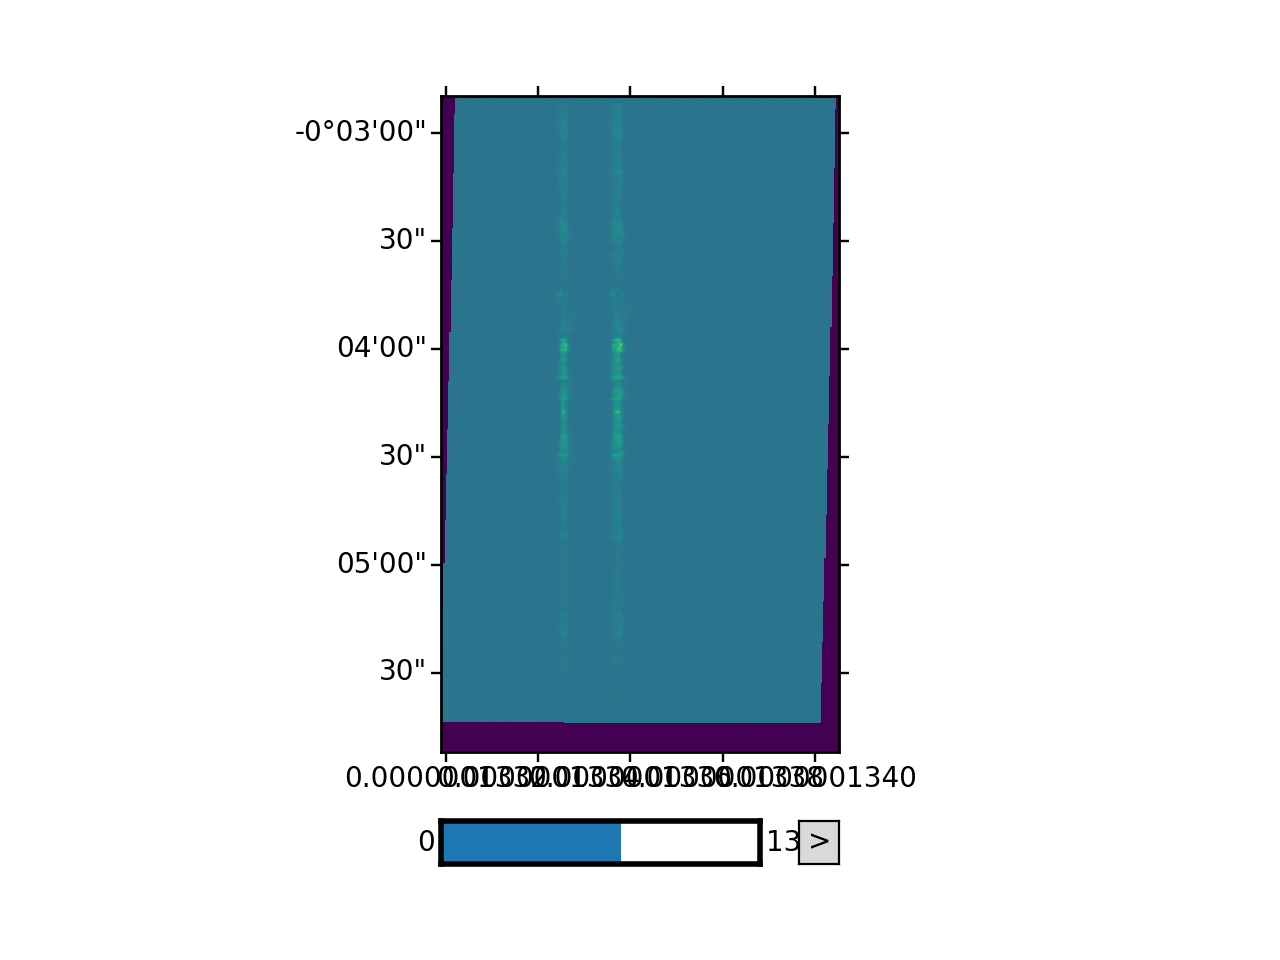

In [119]:
my_sequence.plot()

### Explode Along Axis

During analysis of some data -- say of a stack of images -- it may be necessary to make some different fine-pointing adjustments to each image that isn't accounted for the in the original WCS translations, e.g. due to satellite wobble.  If these changes are not describable with a single WCS object, it may be desirable to break up the N-D sub-cubes of an `NDCubeSequence` into an sequence of sub-cubes with dimension N-1. This would enable a separate WCS object to be associated with each image and hence allow individual pointing adjustments.

Rather than manually dividing the datacubes up and deriving the corresponding WCS object for each exposure, `NDCubeSequence` provides a useful method, `explode_along_axis`. To call it, simply provide the number of the data cube axis along which you wish to break up the sub-cubes.

In [120]:
exploded_sequence = my_sequence.explode_along_axis(0)

In [121]:
# Original sequence shape.
my_sequence.dimensions

(<Quantity 3. pix>,
 <Quantity 8. pix>,
 <Quantity 548. pix>,
 <Quantity 333. pix>)

In [122]:
# Exploded sequence shape.
exploded_sequence.dimensions

(<Quantity 24. pix>, <Quantity 548. pix>, <Quantity 333. pix>)

Note that any cube axis can be input.  A common axis need not be defined.

In [123]:
my_sequence.data

[NDCube
 ---------------------
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
 CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
 CRPIX : 1.0  274.5  4.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
 PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
 CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
 NAXIS : 333  548  8
 ---------------------
 Length of NDCube: [  8. 548. 333.] pix
 Axis Types of NDCube: ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl'),
 NDCube
 ---------------------
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
 CRVAL : 1.3319000000000002e-07  -0.07244916666666666  0.0034150555555555557  
 CRPIX : 1.0  274.5  4.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338403709334  
 PC3_1 PC3_2 PC3_3  : 0.0  0.00376290

In [124]:
exploded_sequence.data

[NDCube
 ---------------------
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
 CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
 CRPIX : 1.0  274.5  4.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
 PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
 CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
 NAXIS : 333  548  1
 ---------------------
 Length of NDCube: [548. 333.] pix
 Axis Types of NDCube: ('custom:pos.helioprojective.lat', 'em.wl'), NDCube
 ---------------------
 WCS Keywords
 
 Number of WCS axes: 3
 CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
 CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
 CRPIX : 1.0  274.5  3.0  
 PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
 PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
 PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
 CDELT : 2.59600